In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


This is a kaggle notebook and the dataset is taken from a competition named new york city fare prediction hosted by google. In this notebook, i will attempt to clean the data, visuallize it if possible and try to use some form of machine learning techniques to predict the taxi fares. Let's start by examining the original dataset. The dataset is extremely big more than python so i will only be looking at 10% of the dataset which is 2 million rows.

In [2]:
train_df = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv',nrows = 2000000, parse_dates=["pickup_datetime"])
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
# check datatypes
train_df.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [4]:
# check statistics of the features
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


# **1. Cleaning Data**

As can be seen from the description table, there are few things to notice here:
* The min fare_amount is negative which is not realistic and to resolve it, i will proceed to drop it

In [5]:
print('Original size: %d' % len(train_df))
train_df = train_df[train_df.fare_amount>=0]
print('New size: %d' % len(train_df))

Original size: 2000000
New size: 1999923


Now we will proceed to look for NULL values as well as cleaning them


In [6]:
train_df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

As can be seen, there are 14 NULL values in dropoff longitude and dropoff latitude which takes up a very small percentage of the dataset so i will also proceed to delete it.

In [7]:
print('Original size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Original size: 1999923
New size: 1999909


A normal taxi can only bring up to 6 passenger maxed so i will remove those that surpassed this limit.

In [8]:
print('Original size: %d' % len(train_df))
train_df = train_df.drop(train_df[train_df['passenger_count']>6].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['passenger_count']<0].index, axis = 'rows')
print('New size: %d' % len(train_df))

Original size: 1999909
New size: 1999907


Longitude and latitude can only be from the range of 180 to -180 and 90 to -190 respectively and so i will also remove values outside of this range.

In [9]:
print('Original size: %d' % len(train_df))
train_df = train_df.drop(train_df[train_df['pickup_longitude']>180].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['pickup_longitude']<-180].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['pickup_latitude']>90].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['pickup_latitude']<-90].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['dropoff_longitude']>180].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['dropoff_longitude']<-180].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['dropoff_latitude']>90].index, axis = 'rows')
train_df = train_df.drop(train_df[train_df['dropoff_latitude']<-90].index, axis = 'rows')
print('New size: %d' % len(train_df))

Original size: 1999907
New size: 1999822


Let's have a final look at our data.

In [10]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999822e+06,1.999822e+06,1.999822e+06,1.999822e+06,1.999822e+06,1.999822e+06
mean,1.134837e+01,-7.251360e+01,3.992579e+01,-7.251554e+01,3.992653e+01,1.684011e+00
std,9.851570e+00,1.040304e+01,6.083561e+00,1.039308e+01,6.081845e+00,1.306833e+00
min,0.000000e+00,-1.281760e+02,-7.401727e+01,-1.219152e+02,-7.403520e+01,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,4.085036e+01,7.400741e+01,4.558162e+01,8.151018e+01,6.000000e+00


# **Data Visualization**

In [11]:
len(train_df[train_df.fare_amount < 100])/len(train_df)

0.9995719619046095

As we can see almost 99.9% of the rides were less than 100 dollars so i'll set a restriction of 100 dollars to rule out some outliers.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


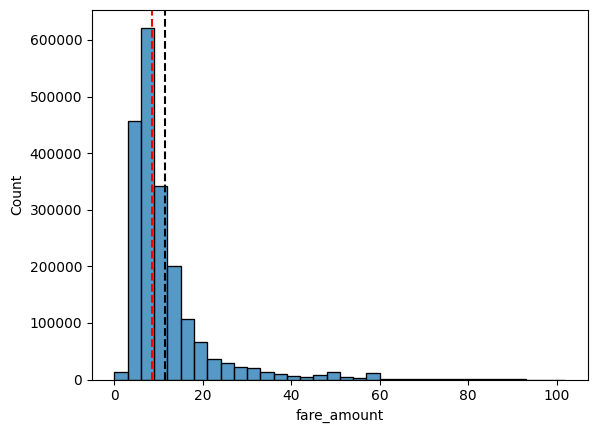

In [12]:
sns.histplot(data=train_df[train_df.fare_amount < 100], x="fare_amount", binwidth=3, bins=200)
plt.axvline(train_df["fare_amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip fare ($)")
plt.axvline(train_df["fare_amount"].median(),color = "r",
            linestyle = "dashed",label = "Median trip fare ($)")

From the graph, it is apparent that most people only book trips in the amount of less than 20 dollars with most of them book rides from 10 dollars or less.

In [13]:
year_col = train_df['pickup_datetime'].dt.year.to_frame()
year_col = year_col.rename(columns={"pickup_datetime":"Year"})
year_df = year_col.join(train_df["passenger_count"]).join(train_df["fare_amount"]).groupby('Year').sum().reset_index()
year_df.head()

,Year,passenger_count,fare_amount
0,2009,520939,3101018.11
1,2010,505023,3061188.40
2,2011,524946,3317583.50
3,2012,544207,3609832.50
4,2013,534197,3940304.89


<Axes: xlabel='Year', ylabel='fare_amount'>

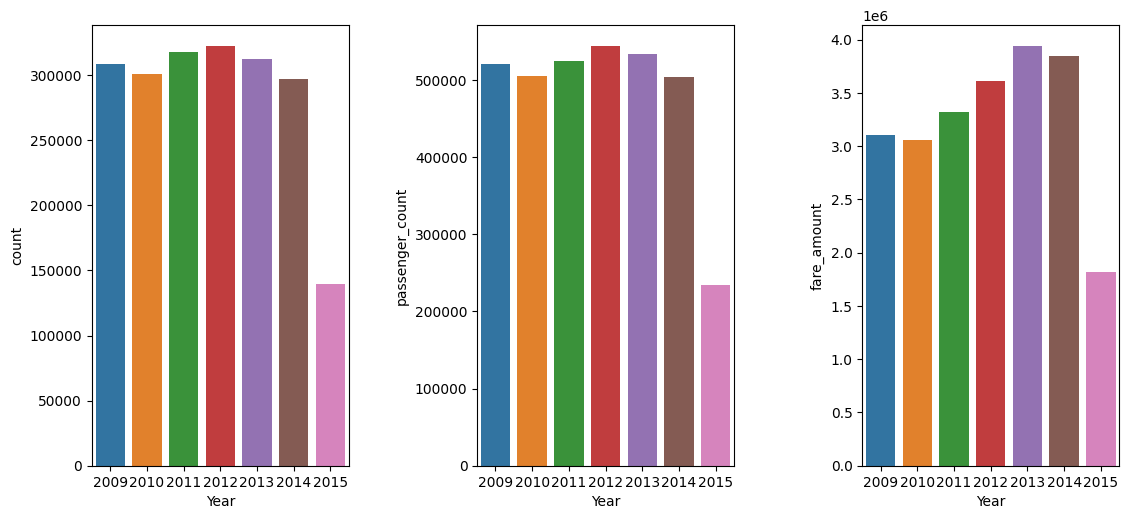

In [14]:
fig, axs = plt.subplots(ncols=3,figsize=(11, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=year_col, x="Year", ax=axs[0])
sns.barplot(data=year_df, x="Year", y="passenger_count", ax=axs[1])
sns.barplot(data=year_df, x="Year", y="fare_amount", ax=axs[2])

From 2009 to 2014, the amount of cab rides and the passenger count stays relative stable, but the price has been rising which may be related to inflation through the year. What is consistent is that the amount of taxi rides, people who booked taxis as well as the cost to book taxis all dramatically decrease in 2015 which may indicate the fall of traditional taxi. I will also continue to do this analysis for day and month.

In [15]:
month_col = train_df['pickup_datetime'].dt.month.to_frame()
month_col = month_col.rename(columns={"pickup_datetime":"Month"})
month_df = month_col.join(train_df["passenger_count"]).join(train_df["fare_amount"]).groupby('Month').sum().reset_index()
month_df.head()

,Month,passenger_count,fare_amount
0,1,300066,1904976.08
1,2,281925,1842851.20
2,3,312109,2093628.04
3,4,309069,2085462.95
4,5,316818,2185008.22


<Axes: xlabel='Month', ylabel='fare_amount'>

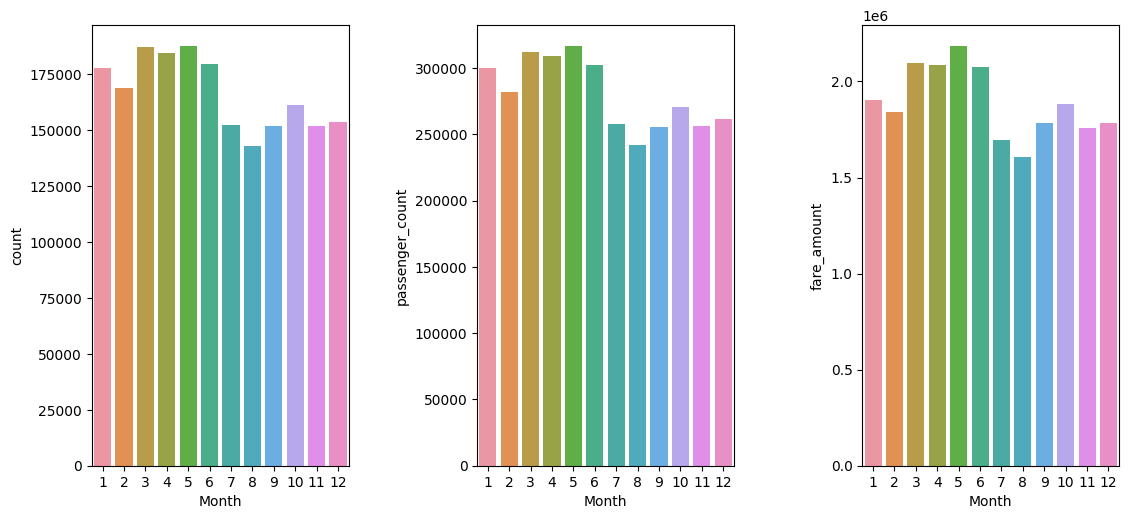

In [16]:
fig, axs = plt.subplots(ncols=3,figsize=(11, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=month_col, x="Month", ax=axs[0])
sns.barplot(data=month_df, x="Month", y="passenger_count", ax=axs[1])
sns.barplot(data=month_df, x="Month", y="fare_amount", ax=axs[2])

Most people seems to travel more on the first half of the years as all parameters measured are bigger in the first half especially on March to June which might be representative of summer traffic.

In [17]:
day_col = train_df['pickup_datetime'].dt.day.to_frame()
day_col = day_col.rename(columns={"pickup_datetime":"Day"})
day_df = day_col.join(train_df["passenger_count"]).join(train_df["fare_amount"]).groupby('Day').sum().reset_index()
day_df.head()

,Day,passenger_count,fare_amount
0,1,104019,707595.86
1,2,103924,700838.59
2,3,105679,711090.23
3,4,105749,709265.68
4,5,108669,728865.23


<Axes: xlabel='Day', ylabel='fare_amount'>

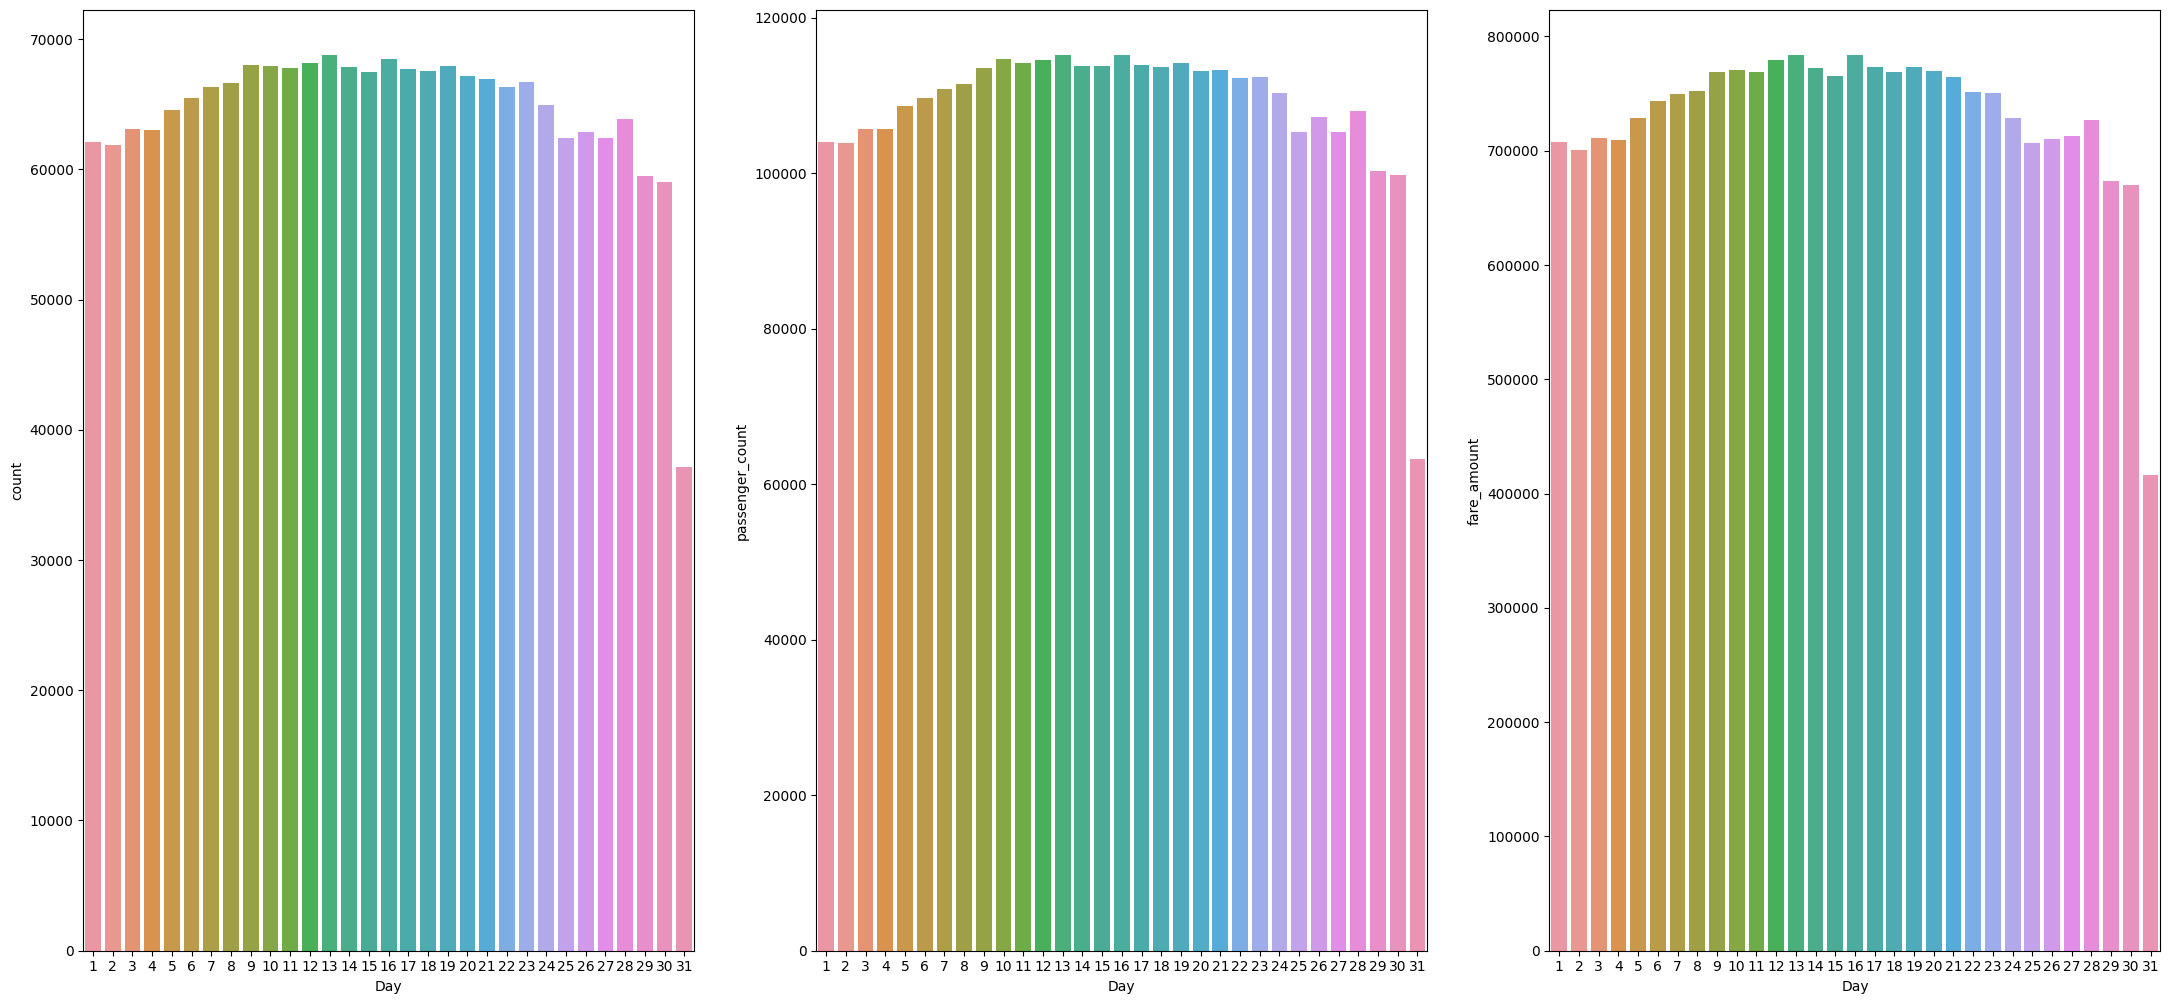

In [18]:
fig, axs = plt.subplots(ncols=3,figsize=(21.5, 10))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
sns.countplot(data=day_col, x="Day", ax=axs[0])
sns.barplot(data=day_df, x="Day", y="passenger_count", ax=axs[1])
sns.barplot(data=day_df, x="Day", y="fare_amount", ax=axs[2])

It seems that the date does not contribute any significance impact to the passenger as it remains stable. On the 31st day, as only half of the months have a 31st day so it is reasonable that the count of rides, passengers and fare amount is half of the other days.

In [19]:
hour_col = train_df['pickup_datetime'].dt.hour.to_frame()
hour_col = hour_col.rename(columns={"pickup_datetime":"Hour"})
hour_df = hour_col.join(train_df["passenger_count"]).join(train_df["fare_amount"]).groupby('Hour').sum().reset_index()
hour_df.head()

,Hour,passenger_count,fare_amount
0,0,138686,926873.39
1,1,101979,670159.70
2,2,75666,500122.43
3,3,56277,385079.34
4,4,40282,316081.62


<Axes: xlabel='Hour', ylabel='fare_amount'>

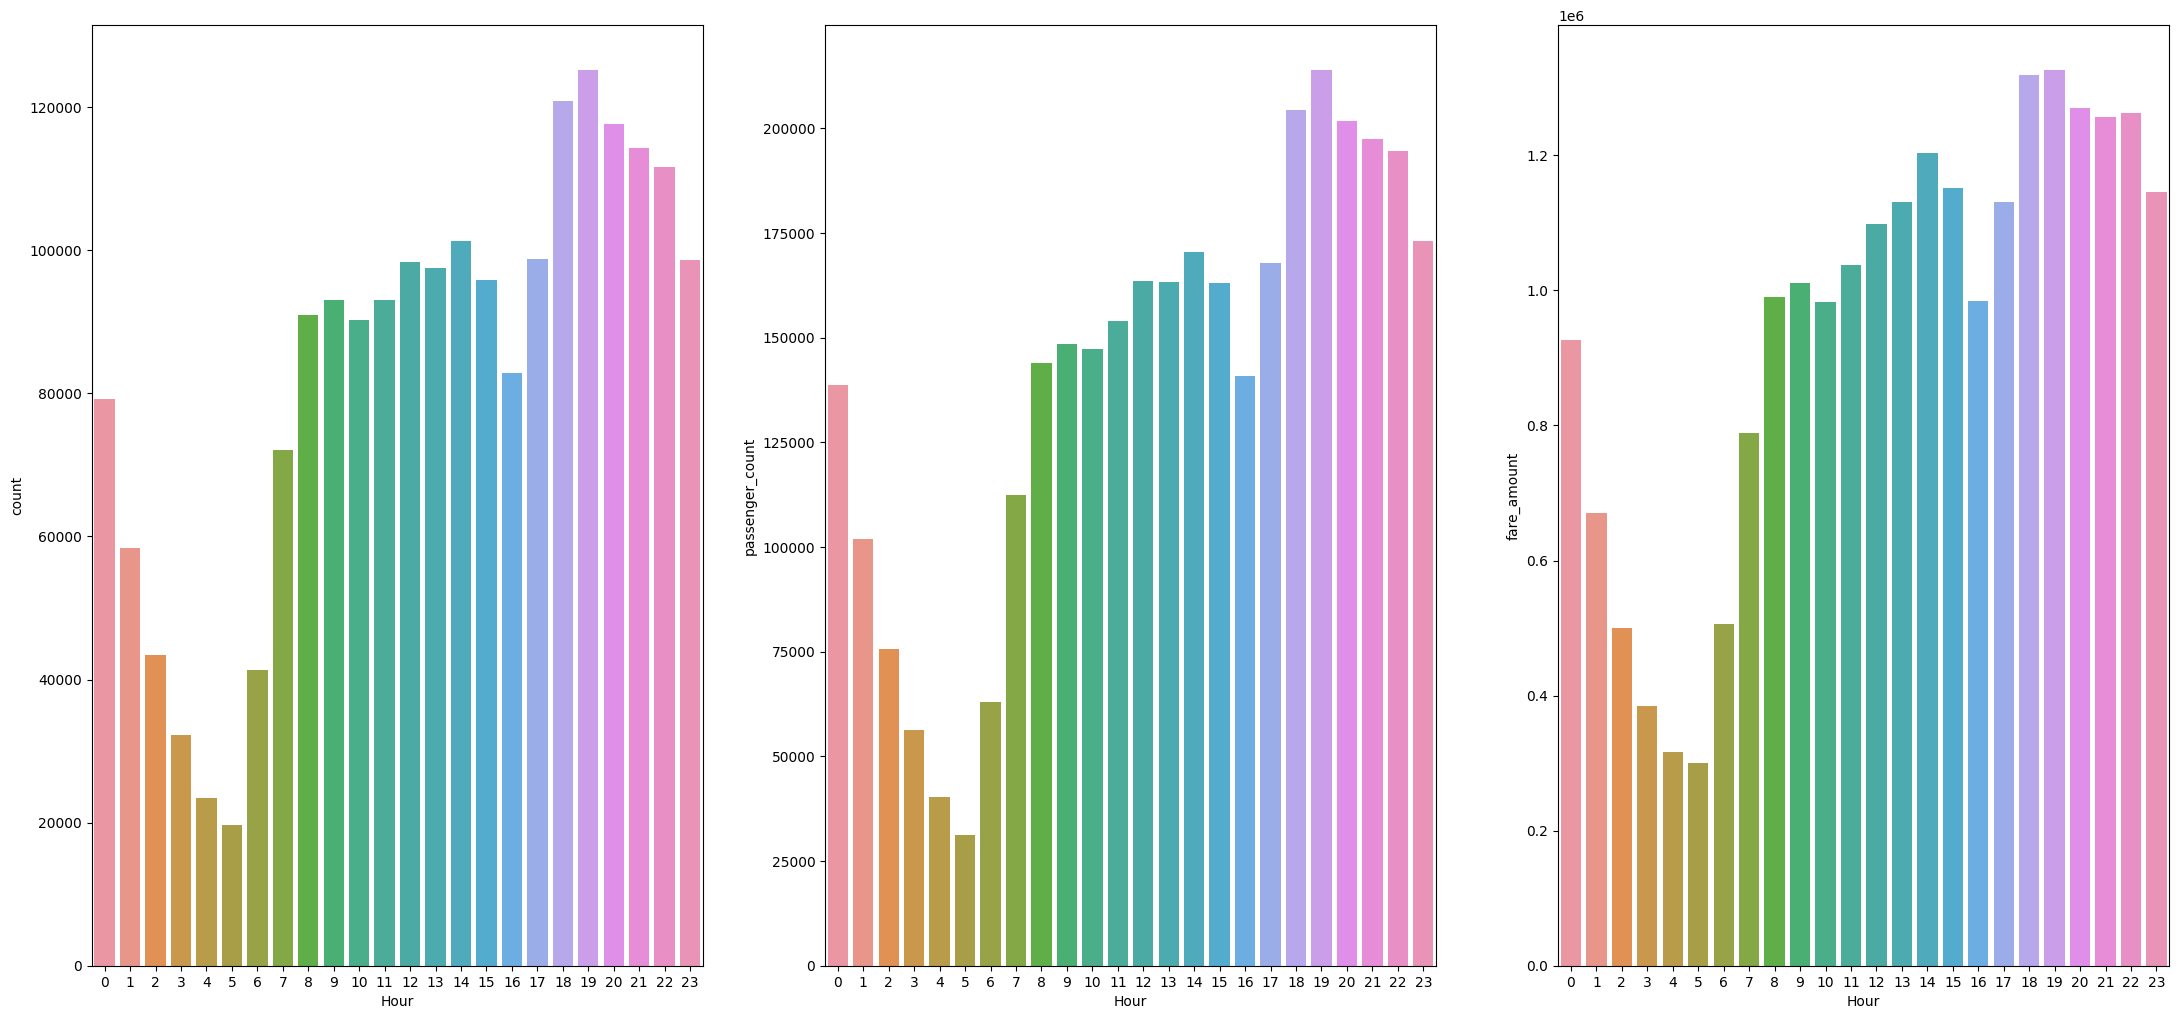

In [20]:
fig, axs = plt.subplots(ncols=3,figsize=(21.5, 10))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
sns.countplot(data=hour_col, x="Hour", ax=axs[0])
sns.barplot(data=hour_df, x="Hour", y="passenger_count", ax=axs[1])
sns.barplot(data=hour_df, x="Hour", y="fare_amount", ax=axs[2])

As can be seen from the graph, fare price have a tendency to increase at night and lower in the morning especially from 3 to 5 AM.

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

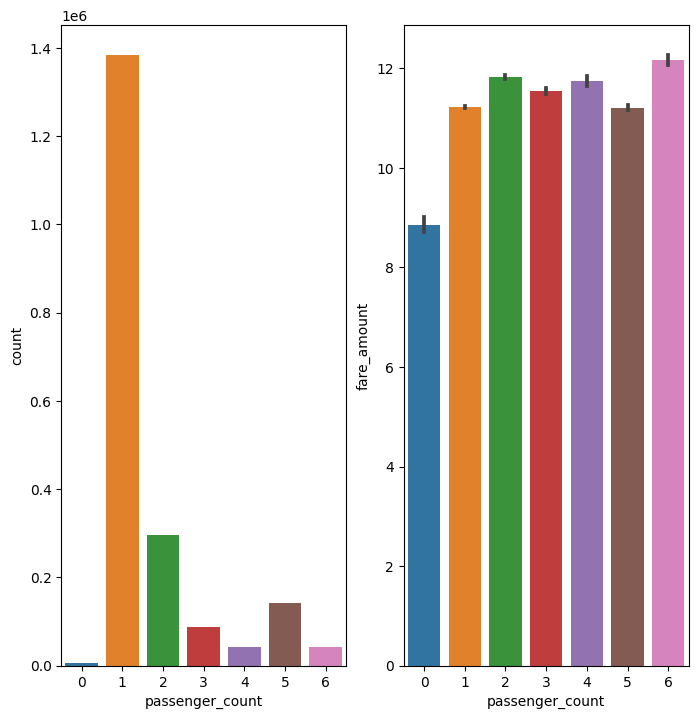

In [21]:
fig, axs = plt.subplots(ncols=2,figsize=(7, 7))
fig.tight_layout()
sns.countplot(data=train_df, x="passenger_count", ax=axs[0])
sns.barplot(data=train_df, x=train_df['passenger_count'], y = train_df['fare_amount'], ax=axs[1])

The coordinates of New York City is -74 and 40 and so i will fix a distance to limit the map to the area of NYC

(-74.03, -73.75)

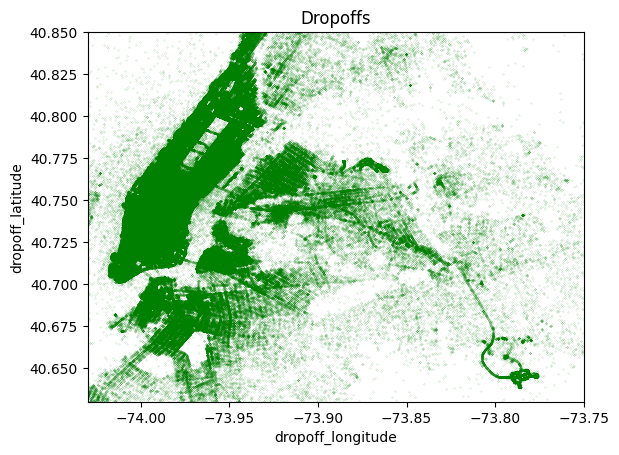

In [22]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train_df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

From the scatter plot of dropoffs, there is a wide area of drop offs but most of them is in the mahattan area and some in public location like JFK airport which is expected.

(-74.03, -73.75)

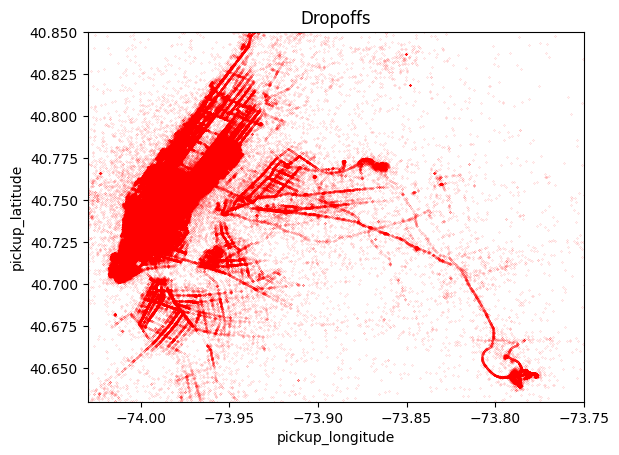

In [23]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train_df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='red', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Customers seems to have less pickups location mostly in residential area and public locations like JFK area.

In [24]:
import haversine as hs
train_df["loc1"] = train_df[["pickup_latitude","pickup_longitude"]].apply(tuple, axis=1)
train_df["loc2"] = train_df[["dropoff_latitude","dropoff_longitude"]].apply(tuple, axis=1)
train_df['H_Distance'] = train_df.apply(lambda row: hs.haversine(row.loc1,row.loc2), axis=1)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,loc1,loc2,H_Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,"(40.721319, -73.844311)","(40.712278, -73.84161)",1.030765
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,"(40.711303, -74.016048)","(40.782004, -73.979268)",8.450145
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,"(40.76127, -73.982738)","(40.750562, -73.991242)",1.389527
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,"(40.733143, -73.98713)","(40.758092, -73.991567)",2.799274
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,"(40.768008, -73.968095)","(40.783762, -73.956655)",1.999160


Because we have a new feature so i need to clean it. Because the distance cannot be 0 so i will check for any zero.

In [25]:
len(train_df[train_df['H_Distance']==0])

56809

There are 56k rows that have a H-Distance equals to zero which amounts to roughly 2.8% of the dataset we are analyzing which can have some impact so i will do it using 2 ways. First methods is just dropping them and second methods is imputation.

# **Dropping the values**

In [32]:
print("Original: " + str(len(train_df)))
train_no0 = train_df.drop(train_df[train_df['passenger_count']==0].index, axis = 'rows')
print("New: " + str(len(train_no0)))

Original: 1999822
New: 1992713


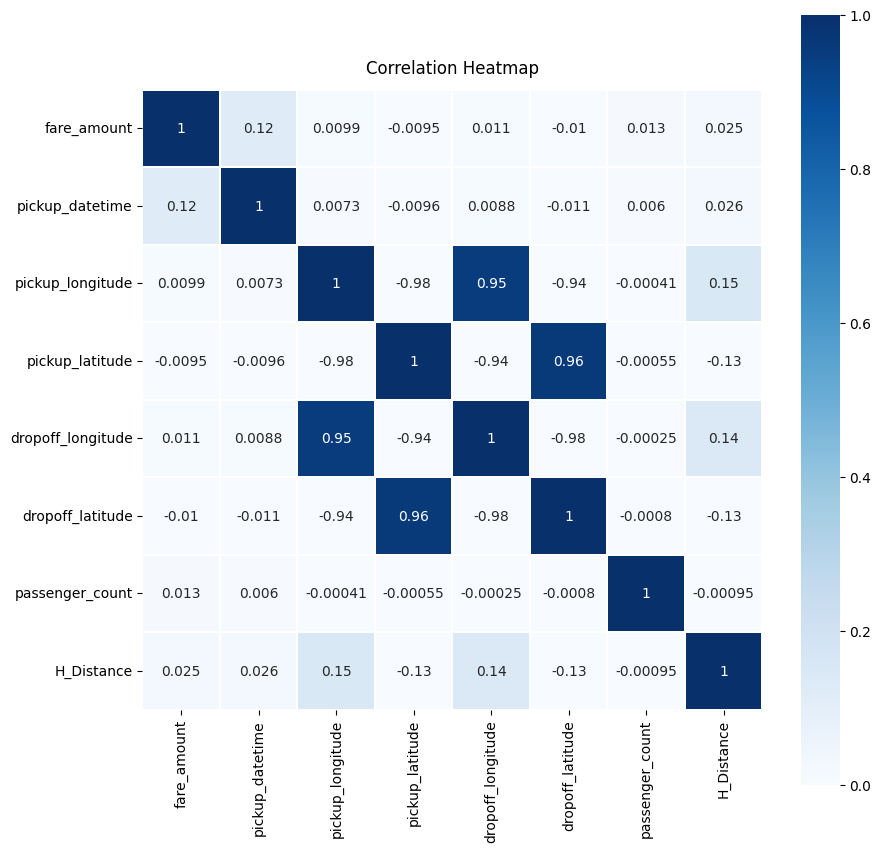

In [28]:
train_df = train_df.drop(columns=['loc1', 'loc2'])
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(train_df.loc[:,'fare_amount':'H_Distance'].corr(),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

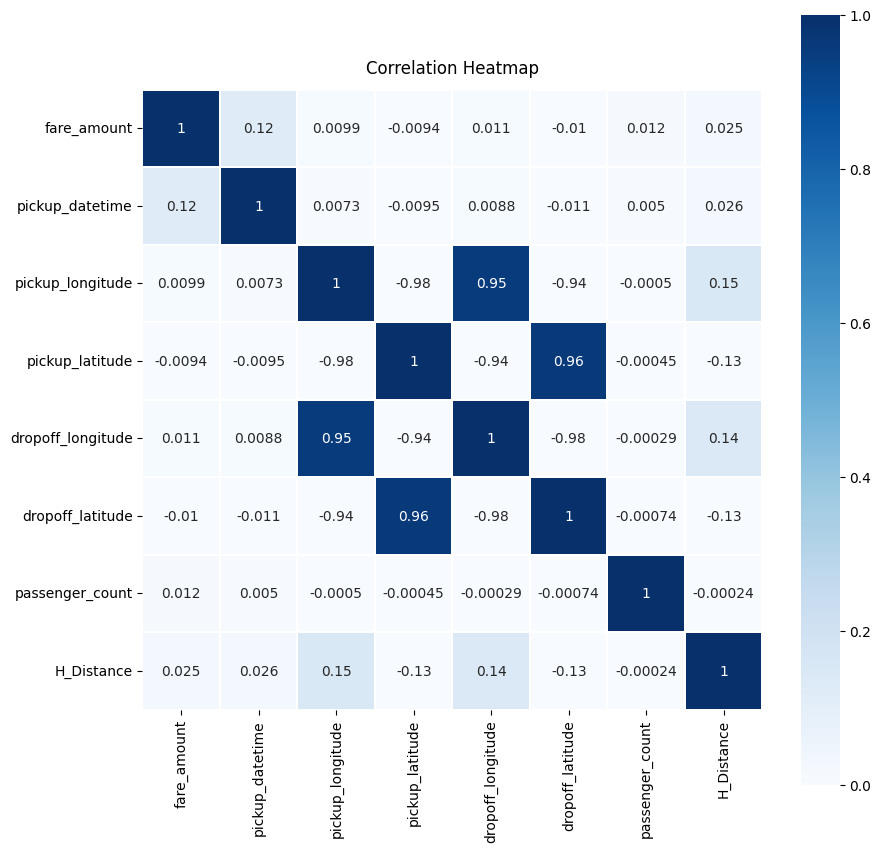

In [33]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(train_no0.loc[:,'fare_amount':'H_Distance'].corr(),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

The change we get is quite negligable so let's move on to imputation

# **Imputation**

There are a few scenrios to why the H_distance can be 0.
* The passenger cancel the trip
* There may be missing values of the drop off coordinates
To make this a little simpler on myself i will only be using the average of the fare_amount as replacement.
There is also a peculiar situtation where the fare amount is 0 but the distance is not 0 that i will also be taking into account

In [34]:
len(train_df[(train_df['H_Distance']==0)&(train_df['fare_amount']==0)])

7

Since it is obvious that with no distance travel comes no cost i will drop the scenarios where both the distance as well as the fare amount is 0.

In [49]:
train_imp = train_df.drop(train_df[(train_df['H_Distance']==0)&(train_df['fare_amount']==0)].index, axis = 'rows')
len(train_imp)

1999815

In [50]:
len(train_imp[(train_imp['H_Distance']==0) & (train_imp['fare_amount']!=0)])

56802

I will replace these fare amount to the average of this dataset.

In [51]:
train_imp.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
count,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06
mean,1.134841e+01,-7.251370e+01,3.992584e+01,-7.251565e+01,3.992658e+01,1.684011e+00,1.929854e+01
std,9.851564e+00,1.040268e+01,6.083375e+00,1.039272e+01,6.081659e+00,1.306835e+00,3.649572e+02
min,0.000000e+00,-1.281760e+02,-7.401727e+01,-1.219152e+02,-7.403520e+01,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,1.212783e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,2.116152e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,3.879823e+00
max,1.273310e+03,4.085036e+01,7.400741e+01,4.558162e+01,8.151018e+01,6.000000e+00,1.259472e+04


In [52]:
train_imp.loc[train_imp.H_Distance == 0,'H_Distance'] = sum(train_imp['H_Distance'])/len(train_imp)
train_imp.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
count,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06
mean,1.134841e+01,-7.251370e+01,3.992584e+01,-7.251565e+01,3.992658e+01,1.684011e+00,1.984669e+01
std,9.851564e+00,1.040268e+01,6.083375e+00,1.039272e+01,6.081659e+00,1.306835e+00,3.649423e+02
min,0.000000e+00,-1.281760e+02,-7.401727e+01,-1.219152e+02,-7.403520e+01,0.000000e+00,8.391650e-05
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,1.301710e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,2.247253e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,4.236451e+00
max,1.273310e+03,4.085036e+01,7.400741e+01,4.558162e+01,8.151018e+01,6.000000e+00,1.259472e+04


In [53]:
len(train_imp[(train_imp['fare_amount']==0)])

49

In [54]:
train_imp.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
count,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06
mean,1.134841e+01,-7.251370e+01,3.992584e+01,-7.251565e+01,3.992658e+01,1.684011e+00,1.984669e+01
std,9.851564e+00,1.040268e+01,6.083375e+00,1.039272e+01,6.081659e+00,1.306835e+00,3.649423e+02
min,0.000000e+00,-1.281760e+02,-7.401727e+01,-1.219152e+02,-7.403520e+01,0.000000e+00,8.391650e-05
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,1.301710e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,2.247253e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,4.236451e+00
max,1.273310e+03,4.085036e+01,7.400741e+01,4.558162e+01,8.151018e+01,6.000000e+00,1.259472e+04


In [55]:
train_imp.loc[train_imp.fare_amount == 0,'fare_amount'] = sum(train_imp['fare_amount'])/len(train_imp)
train_imp.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
count,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06,1.999815e+06
mean,1.134868e+01,-7.251370e+01,3.992584e+01,-7.251565e+01,3.992658e+01,1.684011e+00,1.984669e+01
std,9.851404e+00,1.040268e+01,6.083375e+00,1.039272e+01,6.081659e+00,1.306835e+00,3.649423e+02
min,1.000000e-02,-1.281760e+02,-7.401727e+01,-1.219152e+02,-7.403520e+01,0.000000e+00,8.391650e-05
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,1.301710e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,2.247253e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,4.236451e+00
max,1.273310e+03,4.085036e+01,7.400741e+01,4.558162e+01,8.151018e+01,6.000000e+00,1.259472e+04


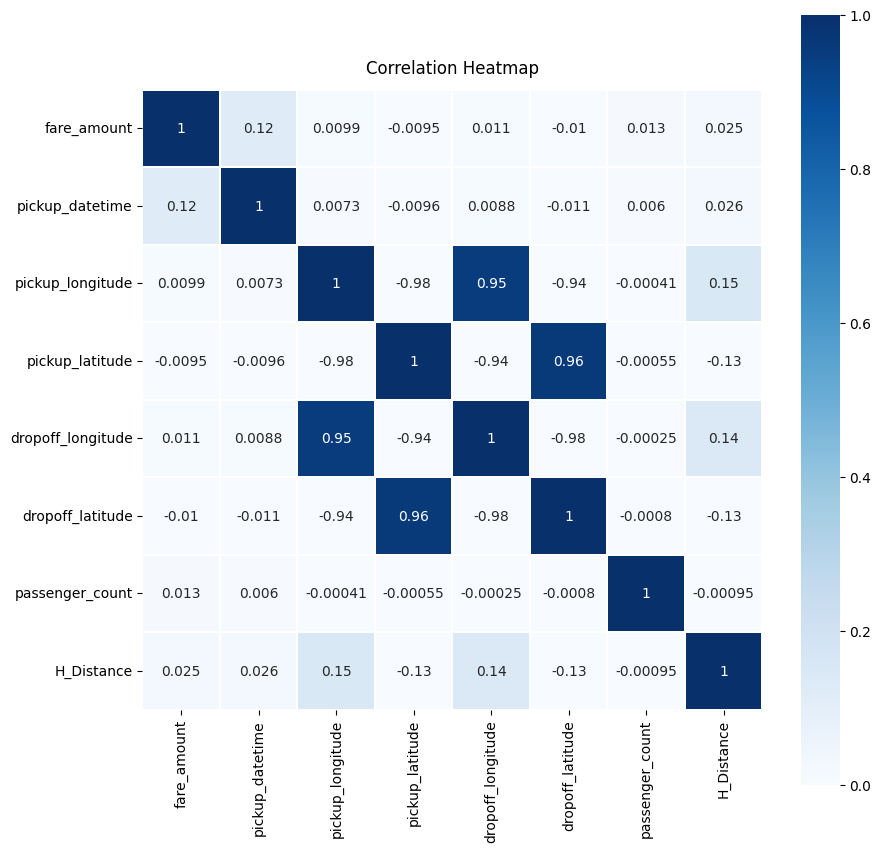

In [56]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(train_df.loc[:,'fare_amount':'H_Distance'].corr(),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

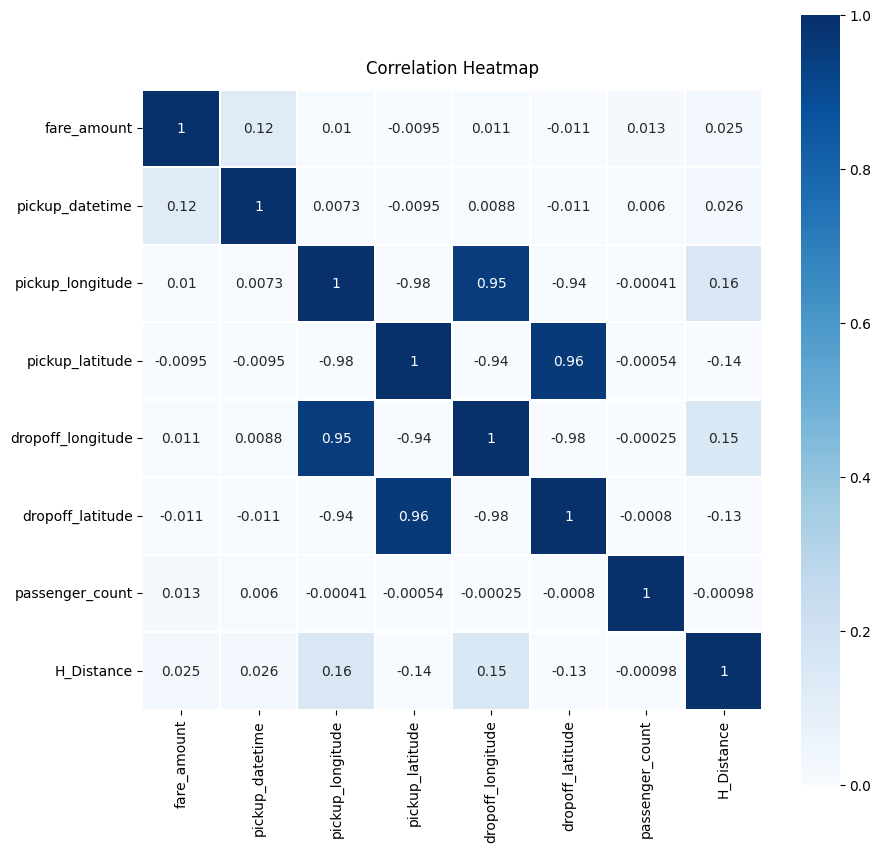

In [57]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(train_imp.loc[:,'fare_amount':'H_Distance'].corr(),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Both the result have very negligable results, i will keep visuallize scatter plot of fare amount, pickup datetime and H distance in both ways to confirm if it is suitable for regression.

<Axes: xlabel='H_Distance', ylabel='fare_amount'>

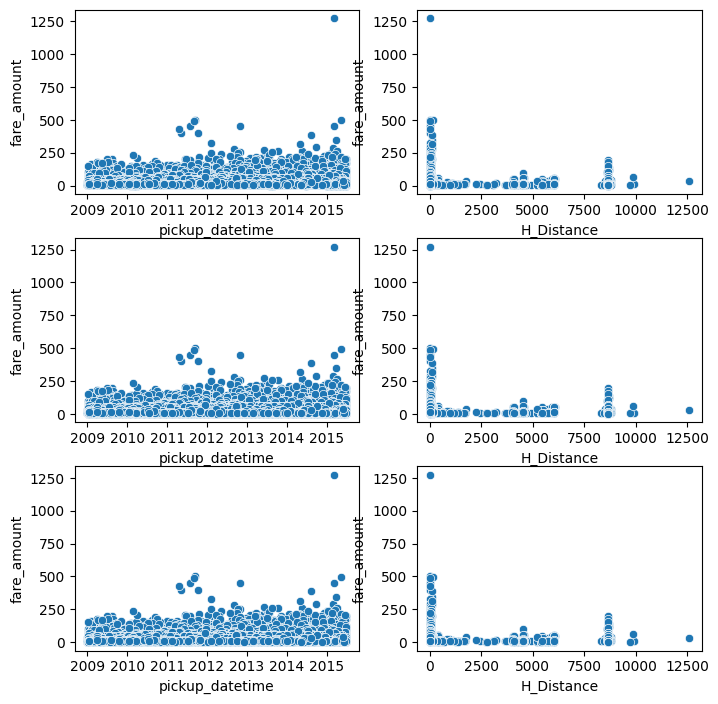

In [60]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(7, 7))
fig.tight_layout()
sns.scatterplot(data=train_no0, x=train_no0['pickup_datetime'], y = train_no0['fare_amount'],ax = axs[0,0])
sns.scatterplot(data=train_no0, x=train_no0['H_Distance'], y = train_no0['fare_amount'],ax = axs[0,1])
sns.scatterplot(data=train_imp, x=train_imp['pickup_datetime'], y = train_imp['fare_amount'],ax = axs[1,0])
sns.scatterplot(data=train_imp, x=train_imp['H_Distance'], y = train_imp['fare_amount'],ax = axs[1,1])
sns.scatterplot(data=train_df, x=train_df['pickup_datetime'], y = train_df['fare_amount'],ax = axs[2,0])
sns.scatterplot(data=train_df, x=train_df['H_Distance'], y = train_df['fare_amount'],ax = axs[2,1])

As we can see from the scatter plot there are very little correlation and it does not scatter in any particular pattern here. So our best bet is to make a neural network for any form of prediction.